In [ ]:
# Importing necessary libraries
import collections
import nltk
import time
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import check_random_state
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, KFold
from nltk.corpus import brown
from nltk.stem import PorterStemmer 
from tqdm import tqdm
! pip install glove_python
import glove
nltk.download('brown')
nltk.download('universal_tagset')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


     |████████████████████████████████| 266kB 4.3MB/s 
  Created wheel for glove-python: filename=glove_python-0.1.0-cp36-cp36m-linux_x86_64.whl size=700261 sha256=b46bb314ffd960a3665f5447b42522809347d5dffefd526041dcd2ffe06feff0
  Stored in directory: /root/.cache/pip/wheels/88/4b/6d/10c0d2ad32c9d9d68beec9694a6f0b6e83ab1662a90a089a4b
Successfully built glove-python
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


True

In [ ]:
# SVM Implementation
class svm():
    def __init__(self, iter, C, rs, epsilon):
        self.iter = iter
        self.C = C
        self.rs = rs
        self.epsilon = epsilon
 
    def fit(self, X, y):
        t = 0
        n = np.array([math.sqrt(f) for f in np.array([sum(d) for d in X**2])])
        self.le = LabelEncoder()
        data_count = X.shape[0]
        y = self.le.fit_transform(y)
        tags_count = len(self.le.classes_)
        self.alpha_i = np.array([[float(0) for p in range(data_count)] for q in range(tags_count)])
        f_count = X.shape[1]
        self.weights = np.array([[float(0) for p in range(f_count)] for q in range(tags_count)])
        initial_v = None
        id = np.array([s for s in range(data_count)])
        check_random_state(self.rs).shuffle(id)
        pbar = tqdm(total=self.iter)
        while t < self.iter:
            pbar.update(1)
            sum_v = 0
            j = 0
            while j < data_count:
                if not n[id[j]]:
                    continue
                g_i = X[id[j]]@self.weights.T + 1
                g_i[y[id[j]]] -= 1
                s = float('inf')
                k = 0
                while k < g_i.shape[0]:
                    if ((self.C <= self.alpha_i[k, id[j]]) and (y[id[j]] == k)) or ((0 <= self.alpha_i[k, id[j]]) and (y[id[j]] != k)):
                        k += 1
                        continue
                    s = min(g_i[k],s)
                    k += 1
                v = max(g_i) - s
                sum_v += v
                if 1e-12 > v:
                    j += 1
                    continue
                C_i = np.array([float(0) for p in range(g_i.shape[0])])
                C_i[y[id[j]]] = self.C
                beta_estimate = (g_i / n[id[j]]) + (C_i - self.alpha_i[:, id[j]])*n[id[j]]
                f_count = beta_estimate.shape[0]
                idx = np.array([q for q in range(1,f_count+1)])
                u = np.array(sorted(beta_estimate)[::-1])    # sorting in decreasing order
                pi = np.array([sum(u[:i]) for i in range(1,len(u)+1)]) - (self.C * n[id[j]]) 
                theta = pi[(u - pi / idx > 0)][-1] / float(idx[(u - pi / idx > 0)][-1])
                beta = np.array([max(p,0) for p in (beta_estimate - theta)])
                delta_i = C_i - self.alpha_i[:, id[j]] - beta / n[id[j]]
                self.alpha_i[:, id[j]] += delta_i
                self.weights += (delta_i * X[id[j]][:, np.newaxis]).T
                j += 1
            if t == 0:
                initial_v = sum_v
            if self.epsilon > (sum_v / initial_v):
                break
            t += 1
        pbar.close()
        return self
 
    def predict(self, X):
        return self.le.inverse_transform(np.dot(X, self.weights.T).argmax(axis=1))
 
    def score(self,X,y):
      y_pred = self.predict(X)
      length = len(y)
      return (sum(y_pred[i] == y[i] for i in range(length)))/length

In [ ]:
import os, requests, shutil

glove_dir = './data/RNN/'
glove_100k_50d = 'glove.first-100k.6B.50d.txt'
glove_100k_50d_path = os.path.join(glove_dir, glove_100k_50d)

# These are temporary files if we need to download it from the original source (slow)
data_cache = './data/cache'
glove_full_tar = 'glove.6B.zip'
glove_full_50d = 'glove.6B.50d.txt'

#force_download_from_original=False
download_url= 'http://redcatlabs.com/downloads/deep-learning-workshop/notebooks/data/RNN/'+glove_100k_50d
original_url = 'http://nlp.stanford.edu/data/'+glove_full_tar

if not os.path.isfile( glove_100k_50d_path ):
    if not os.path.exists(glove_dir):
        os.makedirs(glove_dir)
    
    # First, try to download a pre-prepared file directly...
    response = requests.get(download_url, stream=True)
    if response.status_code == requests.codes.ok:
        print("Downloading 42Mb pre-prepared GloVE file from RedCatLabs")
        with open(glove_100k_50d_path, 'wb') as out_file:
            shutil.copyfileobj(response.raw, out_file)
    else:
        # But, for some reason, RedCatLabs didn't give us the file directly
        if not os.path.exists(data_cache):
            os.makedirs(data_cache)
        
        if not os.path.isfile( os.path.join(data_cache, glove_full_50d) ):
            zipfilepath = os.path.join(data_cache, glove_full_tar)
            if not os.path.isfile( zipfilepath ):
                print("Downloading 860Mb GloVE file from Stanford")
                response = requests.get(download_url, stream=True)
                with open(zipfilepath, 'wb') as out_file:
                    shutil.copyfileobj(response.raw, out_file)
            if os.path.isfile(zipfilepath):
                print("Unpacking 50d GloVE file from zip")
                import zipfile
                zipfile.ZipFile(zipfilepath, 'r').extract(glove_full_50d, data_cache)

        with open(os.path.join(data_cache, glove_full_50d), 'rt') as in_file:
            with open(glove_100k_50d_path, 'wt') as out_file:
                print("Reducing 50d GloVE file to first 100k words")
                for i, l in enumerate(in_file.readlines()):
                    if i>=100000: break
                    out_file.write(l)
    
        # Get rid of tarfile source (the required text file itself will remain)
        #os.unlink(zipfilepath)
        #os.unlink(os.path.join(data_cache, glove_full_50d))

print("GloVE available locally")

GloVE available locally


In [ ]:
# Preparing the data for the features and performing data pre-processing for training data
tag2val = {'NOUN':1, 'VERB':2, 'ADP':3, '.':4, 'DET':5, 'ADJ':6, 'ADV':7, 'CONJ':8, 'PRON':9, 'PRT':10, 'NUM':11, 'X':12}
val2tag = {1:'NOUN', 2:'VERB', 3:'ADP', 4:'.', 5:'DET', 6:'ADJ', 7:'ADV', 8:'CONJ', 9:'PRON', 10:'PRT', 11:'NUM', 12:'X'}
prefixes = ['a', 'an', 'ab', 'ad', 'anti', 'ante', 'auto', 'bi-', 'ben', 'co', 'com', 'con', 'circum', 'contra', 'counter', 'ex-', 'dis', 'kilo', 'hyper', 'semi', 'sub', 'super', 'tele', 'tri', 'ultra', 'under', 'vice-', 'mono', 'out', 'un', 'im', 'in', 'ir', 'il', 'non', 'dis', 'di']
suffixes = ['acy', 'al', 'ence', 'ance', 'dom', 'er', 'eer', 'or', 'ism', 'ist', 'ity', 'ship', 'ment', 'ness', 'ion', 'sion', 'th', 'tion', 'ate', 'ed', 'en', 'er', 'ify', 'ing', 'fy', 'ize', 'ise','able', 'ible', 'al', 'ant', 'ary', 'esque', 'ful', 'ic', 'ical', 'ious', 'ous', 'ish', 'ive', 'less', 'y','ly', 'wise', 'ward', 'wards']
noun_suffixes = ['acy', 'al', 'ence', 'ance', 'dom', 'er', 'eer', 'or', 'ism', 'ist', 'ity', 'ship', 'ment', 'ness', 'ion', 'sion', 'th', 'tion']
verb_suffixes = ['ate', 'ed', 'en', 'er', 'ify', 'ing', 'fy', 'ize', 'ise']
adj_suffixes = ['able', 'ible', 'al', 'ant', 'ary', 'esque', 'ful', 'ic', 'ical', 'ious', 'ous', 'ish', 'ive', 'less', 'y']
adverb_suffixes = ['ly', 'wise', 'ward', 'wards']
noun_prefixes = ['a', 'an', 'ab', 'ad', 'anti', 'ante', 'auto', 'bi-', 'ben', 'co', 'com', 'con', 'circum', 'contra', 'counter', 'ex-', 'dis', 'kilo', 'hyper', 'semi', 'sub', 'super', 'tele', 'tri', 'ultra', 'under', 'vice-', 'mono', 'out']
adj_prefixes = ['un', 'im', 'in', 'ir', 'il', 'non', 'dis', 'di']

def processing(corpus):
  i = 0
  n = 0
  words = []
  y = []
  while i < len(corpus):
    for v in corpus[i]:
      n += 1
      words.append(v[0])
      y.append(tag2val[v[1]])
    i += 1
  X = [[] for _ in range(n)]
  word_embedding = glove.Glove.load_stanford( glove_100k_50d_path )
  def get_embedding_vec(word):
      idx = word_embedding.dictionary.get(word.lower(), -1)
      if idx<0:
          return np.zeros(50, dtype='float32')  
      return word_embedding.word_vectors[idx]
  word_embeddings = []
  for z in words:
    word_embeddings.append(get_embedding_vec(z)) 
  le = LabelEncoder()
  l_enc = le.fit_transform(words)
  max_l_enc = max(l_enc) 
  for i in range(len(l_enc)):
    l_enc[i] = (l_enc[i]/max_l_enc)*10
  ps = PorterStemmer()
  stems = []
  for w in words:
    stems.append(ps.stem(w))
  enc = le.fit_transform(stems)
  max_enc = max(enc)
  for i in range(len(enc)):
    enc[i] = (enc[i]/max_enc)
  y = np.array(y)
  return X,y,words,word_embeddings,enc,l_enc,n

# # splitting the corpus into two for now
# s = time.time()
# train_corpus, test_corpus = train_test_split(brown.tagged_sents(tagset='universal'), test_size=0.2, random_state = 0)
# e = time.time()
# print("splitting time = {}".format(e - s))

In [ ]:
# Function to get the features for the training and testing corpus
def get_features(X,words,word_embeddings,enc,l_enc,start,n):
  s = time.time()
  for i in tqdm(range(start,n)):
    if i == 0 or i == 1:
      X[i].extend(word_embeddings[0])
      X[i].extend(word_embeddings[0])
    else: 
      X[i].extend(word_embeddings[i-2]) 
      X[i].extend(word_embeddings[i-1]) 
    X[i].extend(word_embeddings[i])
    if i == (n-2) or i == (n-1):
      X[i].extend(word_embeddings[n-1])
      X[i].extend(word_embeddings[n-1])
    else:
      X[i].extend(word_embeddings[i+1])
      X[i].extend(word_embeddings[i+2])
    X[i].append(1 if (len(words[i]) <= 4) else 0)
    X[i].append(1 if words[i].islower() else 0)
    X[i].append(1 if words[i].isupper() else 0)
    X[i].append(1 if (words[i][0].isupper() and not words[i].isupper()) else 0)
    X[i].append(1 if (any(map(str.isdigit, words[i]))) else 0)
    X[i].append(1 if (words[i] in noun_suffixes) else 0)
    X[i].append(1 if (words[i] in verb_suffixes) else 0)
    X[i].append(1 if (words[i] in adj_suffixes) else 0)
    X[i].append(1 if (words[i] in adverb_suffixes) else 0)
    X[i].append(1 if (words[i] in noun_prefixes) else 0)
    X[i].append(1 if (words[i] in adj_prefixes) else 0)
    for l in range(len(prefixes)):
      X[i].append(1 if (prefixes[l] in words[i]) else 0)
    for m in range(len(suffixes)):
      X[i].append(1 if (suffixes[m] in words[i]) else 0)
    X[i].append(l_enc[i])
    X[i].append(enc[i])
  # k = 3
  # for i in tqdm(range(start,start+k)):
  #   for j in range(k-i): 
  #     X[i].append(1 if (len(words[0]) <= 4) else 0)
  #     X[i].append(1 if words[0].islower() else 0)
  #     X[i].append(1 if words[0].isupper() else 0)
  #     X[i].append(1 if (words[0][0].isupper() and not words[0].isupper()) else 0)
  #     X[i].append(1 if (any(map(str.isdigit, words[0]))) else 0)
  #     X[i].append(1 if (words[0] in noun_suffixes) else 0)
  #     X[i].append(1 if (words[0] in verb_suffixes) else 0)
  #     X[i].append(1 if (words[0] in adj_suffixes) else 0)
  #     X[i].append(1 if (words[0] in adverb_suffixes) else 0)
  #     X[i].append(1 if (words[0] in noun_prefixes) else 0)
  #     X[i].append(1 if (words[0] in adj_prefixes) else 0)
  #     for l in range(len(prefixes)):
  #       X[i].append(1 if (prefixes[l] in words[0]) else 0)
  #     for m in range(len(suffixes)):
  #       X[i].append(1 if (suffixes[m] in words[0]) else 0)
  #     X[i].append(l_enc[0])
  #     X[i].append(enc[0])
  #   for j in range(i+k+1):
  #     X[i].append(1 if (len(words[j]) <= 4) else 0)
  #     X[i].append(1 if words[j].islower() else 0)
  #     X[i].append(1 if words[j].isupper() else 0)
  #     X[i].append(1 if (words[j][0].isupper() and not words[j].isupper()) else 0)
  #     X[i].append(1 if (any(map(str.isdigit, words[j]))) else 0)
  #     X[i].append(1 if (words[j] in noun_suffixes) else 0)
  #     X[i].append(1 if (words[j] in verb_suffixes) else 0)
  #     X[i].append(1 if (words[j] in adj_suffixes) else 0)
  #     X[i].append(1 if (words[j] in adverb_suffixes) else 0)
  #     X[i].append(1 if (words[j] in noun_prefixes) else 0)
  #     X[i].append(1 if (words[j] in adj_prefixes) else 0)
  #     for l in range(len(prefixes)):
  #       X[i].append(1 if (prefixes[l] in words[j]) else 0)
  #     for m in range(len(suffixes)):
  #       X[i].append(1 if (suffixes[m] in words[j]) else 0)
  #     X[i].append(l_enc[j])
  #     X[i].append(enc[j])
  # for i in tqdm(range(start+k,start+n-k)):
  #   for j in range(i-k,i+k+1):
  #     X[i].append(1 if (len(words[j]) <= 4) else 0)
  #     X[i].append(1 if words[j].islower() else 0)
  #     X[i].append(1 if words[j].isupper() else 0)
  #     X[i].append(1 if (words[j][0].isupper() and not words[j].isupper()) else 0)
  #     X[i].append(1 if (any(map(str.isdigit, words[j]))) else 0)
  #     X[i].append(1 if (words[j] in noun_suffixes) else 0)
  #     X[i].append(1 if (words[j] in verb_suffixes) else 0)
  #     X[i].append(1 if (words[j] in adj_suffixes) else 0)
  #     X[i].append(1 if (words[j] in adverb_suffixes) else 0)
  #     X[i].append(1 if (words[j] in noun_prefixes) else 0)
  #     X[i].append(1 if (words[j] in adj_prefixes) else 0)
  #     for l in range(len(prefixes)):
  #       X[i].append(1 if (prefixes[l] in words[j]) else 0)
  #     for m in range(len(suffixes)):
  #       X[i].append(1 if (suffixes[m] in words[j]) else 0)
  #     X[i].append(l_enc[j])
  #     X[i].append(enc[j])
  # for i in tqdm(range(start+n-k,start+n)):
  #   for j in range(i-k,n):
  #     X[i].append(1 if (len(words[j]) <= 4) else 0)
  #     X[i].append(1 if words[j].islower() else 0)
  #     X[i].append(1 if words[j].isupper() else 0)
  #     X[i].append(1 if (words[j][0].isupper() and not words[j].isupper()) else 0)
  #     X[i].append(1 if (any(map(str.isdigit, words[j]))) else 0)
  #     X[i].append(1 if (words[j] in noun_suffixes) else 0)
  #     X[i].append(1 if (words[j] in verb_suffixes) else 0)
  #     X[i].append(1 if (words[j] in adj_suffixes) else 0)
  #     X[i].append(1 if (words[j] in adverb_suffixes) else 0)
  #     X[i].append(1 if (words[j] in noun_prefixes) else 0)
  #     X[i].append(1 if (words[j] in adj_prefixes) else 0)
  #     for l in range(len(prefixes)):
  #       X[i].append(1 if (prefixes[l] in words[j]) else 0)
  #     for m in range(len(suffixes)):
  #       X[i].append(1 if (suffixes[m] in words[j]) else 0)
  #     X[i].append(l_enc[j])
  #     X[i].append(enc[j])
  #   for j in range(k-(n-i)+1):
  #     X[i].append(1 if (len(words[n-1]) <= 4) else 0)
  #     X[i].append(1 if words[n-1].islower() else 0)
  #     X[i].append(1 if words[n-1].isupper() else 0)
  #     X[i].append(1 if (words[n-1][0].isupper() and not words[n-1].isupper()) else 0)
  #     X[i].append(1 if (any(map(str.isdigit, words[n-1]))) else 0)
  #     X[i].append(1 if (words[n-1] in noun_suffixes) else 0)
  #     X[i].append(1 if (words[n-1] in verb_suffixes) else 0)
  #     X[i].append(1 if (words[n-1] in adj_suffixes) else 0)
  #     X[i].append(1 if (words[n-1] in adverb_suffixes) else 0)
  #     X[i].append(1 if (words[n-1] in noun_prefixes) else 0)
  #     X[i].append(1 if (words[n-1] in adj_prefixes) else 0)
  #     for l in range(len(prefixes)):
  #       X[i].append(1 if (prefixes[l] in words[n-1]) else 0)
  #     for m in range(len(suffixes)):
  #       X[i].append(1 if (suffixes[m] in words[n-1]) else 0)
  #     X[i].append(l_enc[n-1])
  #     X[i].append(enc[n-1])
  e = time.time()
  print('Time taken in preparing features = {}'.format(e-s))
  X = np.array(X)
  return X

In [ ]:
# Function to train the svm model
def svm_training(X,y):
    # Training the svm model
    clf = svm(iter=10, C=0.1, rs = 0, epsilon=0.01)
    start = time.time()
    clf.fit(X, y)
    end = time.time()
    print("training time = {}".format(end - start))
    print(clf.score(X, y))
    return clf

In [ ]:
# # Loading the pre-trained word embeddings on GoogleNews dataset 
# s = time.time()
# model = gensim.models.KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin.gz', binary=True)
# e = time.time()
# print('Time taking in loading word2vec = {}'.format(e-s))

# X_train, y_train, train_words, train_word_embeddings, train_enc, train_l_enc, n_train = processing(train_corpus)
# X_test, y_test, test_words, test_word_embeddings, test_enc, test_l_enc, n_test = processing(test_corpus)

# # Preparing the features for the training dataset to be used as input to the svm model
# X_train = get_features(X_train,train_words,train_word_embeddings,train_enc,train_l_enc,0,n_train)

# # Preparing the features for the test dataset
# X_test = get_features(X_test,test_words,test_word_embeddings,test_enc,test_l_enc,0,n_test)

# clf = svm_training(X_train,y_train)

# print(clf.score(X_test,y_test)

In [ ]:
# function for analysing testing data
def analyze_test_data(corpus, predicted_tags, y):
    confusion_matrix = np.zeros([12, 12], dtype=np.int32)
    for i in range(len(y)):
        confusion_matrix[predicted_tags[i]-1, y[i]-1] += 1
    return confusion_matrix

# function which does cross validation analysis by generating confusion matrix
def svm_confusion():
    confusion_matrix_train = np.zeros([12,12], dtype=np.int32)
    confusion_matrix_test = np.zeros([12,12], dtype=np.int32)
    corpus = np.array(brown.tagged_sents(tagset='universal'))
    kf = KFold(n_splits=5, shuffle=True)
    kf.get_n_splits(corpus)
    
    for train_index, test_index in kf.split(corpus):
        train_corpus = corpus[train_index]
        test_corpus = corpus[test_index]
        X_train, y_train, train_words, train_word_embeddings, train_enc, train_l_enc, n_train = processing(train_corpus)
        X_test, y_test, test_words, test_word_embeddings, test_enc, test_l_enc, n_test = processing(test_corpus)
        X_train = get_features(X_train,train_words,train_word_embeddings,train_enc,train_l_enc,0,n_train)
        X_test = get_features(X_test,test_words,test_word_embeddings,test_enc,test_l_enc,0,n_test)
        clf = svm_training(X_train,y_train)
        train_pred = clf.predict(X_train)
        test_pred = clf.predict(X_test)
        print('training size:', len(train_index))
        print('testing size:', len(test_index))
        confusion_matrix_train += analyze_test_data(train_corpus, train_pred, y_train)
        confusion_matrix_test += analyze_test_data(test_corpus, test_pred, y_test)
    return confusion_matrix_train, confusion_matrix_test

def analyze_confusion(confusion_matrix, data='test'):
    
    # accuracy computation
    total_examples = np.sum(confusion_matrix)
    correct_predictions = np.trace(confusion_matrix)
    print('The overall accuracy of the svm model is:', correct_predictions * 100 / total_examples)
    
    # storing the confusion matrix in the form of csv file
    tag_list = [val2tag[i] for i in range(1,13)]
    confusion_df = pd.DataFrame(confusion_matrix, index=tag_list, columns=tag_list)
    confusion_df.to_csv('svm_confusion_matrix_' + data + '.csv')
    
    # plotting the heat map
    plt.figure(figsize = (20, 20))
    confusion_figure = sns.heatmap(confusion_matrix, annot=True, xticklabels=tag_list, yticklabels=tag_list)
    plt.savefig('svm_confusion_figure_' + data + '.png')
    
    # per POS tag statistics
    per_pos_dict = {'tag': [], 'precision': [], 'recall': [], 'f1-score': []}
    for tag_id in range(len(tag_list)):
        per_pos_dict['precision'].append(confusion_matrix[tag_id, tag_id] / np.sum(confusion_matrix[tag_id, :]))
        per_pos_dict['recall'].append(confusion_matrix[tag_id, tag_id] / np.sum(confusion_matrix[:, tag_id]))
        per_pos_dict['tag'].append(tag_list[tag_id])
        per_pos_dict['f1-score'].append(2 * per_pos_dict['precision'][tag_id] * per_pos_dict['recall'][tag_id] / (per_pos_dict['recall'][tag_id] + per_pos_dict['precision'][tag_id]))
    per_pos_df = pd.DataFrame(per_pos_dict)
    per_pos_df.to_csv('svm_per_pos_accuracy_' + data + '.csv')
    return per_pos_dict

def histogram_plot(tag_list,per_pos_dict,data='test'):
    rel_freq_tag = {
    'NUM': 0.013,
    '.': 0.127,
    'VERB': 0.157,
    'ADP': 0.124,
    'ADV': 0.048,
    'PRT': 0.026,
    'DET': 0.118,
    'X': 0.001,
    'PRON': 0.042,
    'ADJ': 0.072,
    'NOUN': 0.24,
    'CONJ': 0.033
    }
    # tag_histogram
    tag_histogram = [rel_freq_tag[tag] for tag in tag_list]

    # scatter plot for frequency vs f1-score for every tag
    tag_f1_score = np.nan_to_num(per_pos_dict['f1-score'])
    plt.figure()
    plt.scatter(tag_histogram, tag_f1_score)
    plt.title('Relative Frequency vs f1-score scatter plot')
    plt.xlabel('Relative Frequency of tag')
    plt.ylabel('F1 score')
    plt.savefig('svm_scatter_plot_' + data + '.png')

In [ ]:
confusion_matrix_train, confusion_matrix_test = svm_confusion()

100%|██████████| 930893/930893 [00:36<00:00, 25786.88it/s]


Time taken in preparing features = 36.10244846343994


100%|██████████| 230299/230299 [00:07<00:00, 29339.50it/s]


Time taken in preparing features = 7.856008768081665


100%|██████████| 10/10 [15:34<00:00, 93.45s/it]


training time = 995.7922332286835
0.8057177355507024
training size: 45872
testing size: 11468


  1%|▏         | 3153/232477 [00:00<00:07, 31525.90it/s]

Time taken in preparing features = 33.85466170310974


100%|██████████| 232477/232477 [00:07<00:00, 29489.74it/s]


Time taken in preparing features = 7.886952877044678


100%|██████████| 10/10 [14:55<00:00, 89.51s/it]


training time = 953.364315032959
0.8379298277727828
training size: 45872
testing size: 11468


  1%|          | 2255/232031 [00:00<00:10, 22549.00it/s]

Time taken in preparing features = 34.86946702003479


100%|██████████| 232031/232031 [00:08<00:00, 28482.09it/s]


Time taken in preparing features = 8.152819871902466


100%|██████████| 10/10 [15:26<00:00, 92.64s/it]


training time = 986.4232966899872
0.8470017574995076
training size: 45872
testing size: 11468


  1%|▏         | 3029/232836 [00:00<00:07, 30282.23it/s]

Time taken in preparing features = 36.72467565536499


100%|██████████| 232836/232836 [00:08<00:00, 27116.54it/s]


Time taken in preparing features = 8.593658685684204


100%|██████████| 10/10 [15:12<00:00, 91.22s/it]


training time = 970.5247929096222
0.8308903050123013
training size: 45872
testing size: 11468


  1%|          | 2725/233549 [00:00<00:08, 27242.43it/s]

Time taken in preparing features = 34.05115342140198


100%|██████████| 233549/233549 [00:08<00:00, 28737.68it/s]


Time taken in preparing features = 8.134552478790283


100%|██████████| 10/10 [15:17<00:00, 91.79s/it]


training time = 976.1265139579773
0.8465638181929902
training size: 45872
testing size: 11468


The overall accuracy of the svm model is: 83.24893729891353


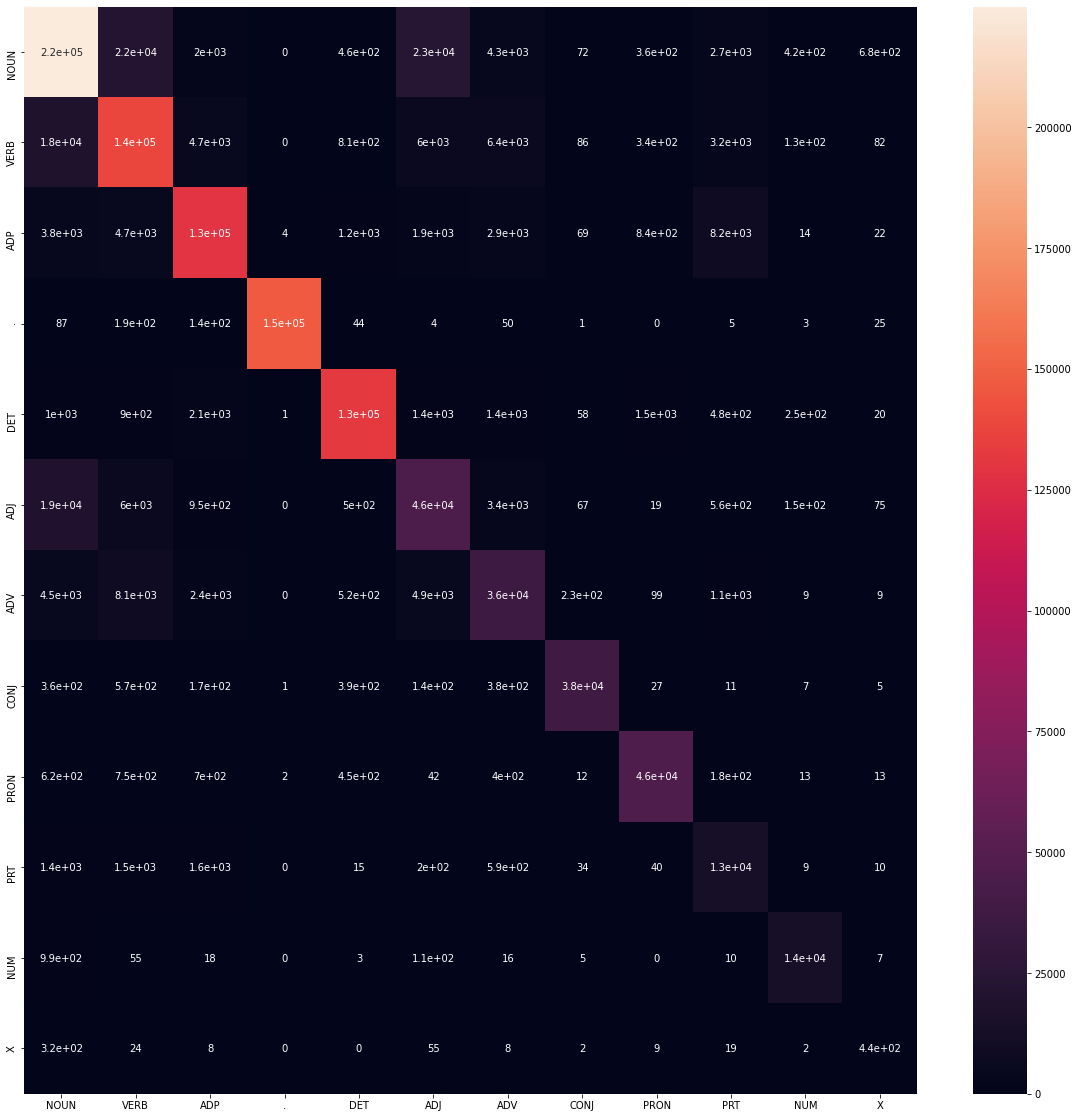

In [ ]:
per_pos_dict_test = analyze_confusion(confusion_matrix_test, data='test')

The overall accuracy of the svm model is: 83.36061133731545


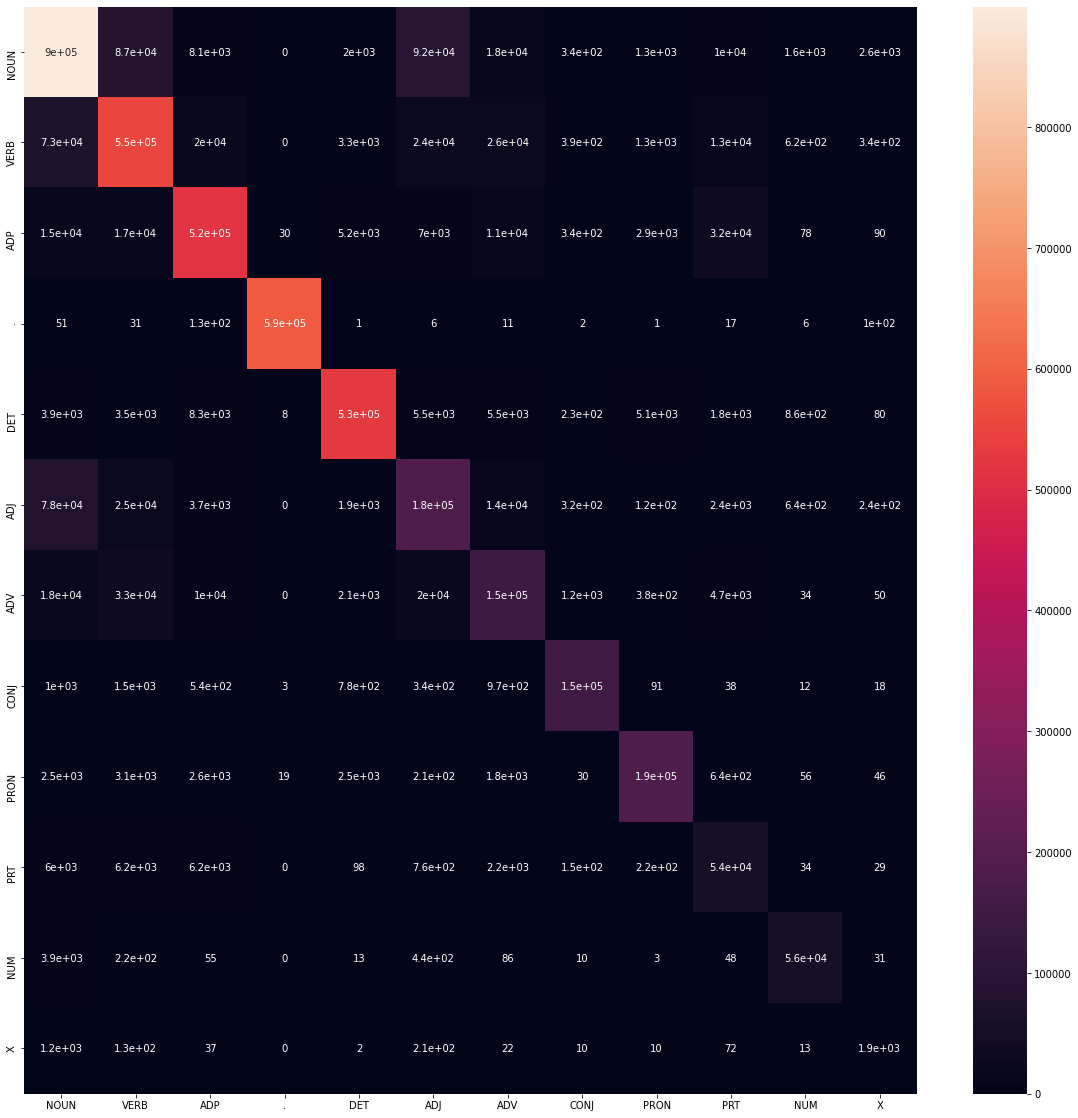

In [ ]:
per_pos_dict_train = analyze_confusion(confusion_matrix_train, data='train')

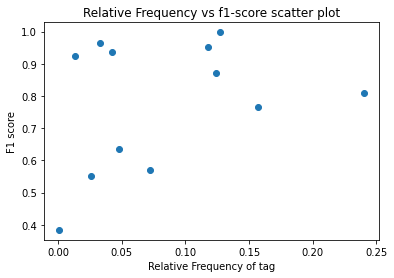

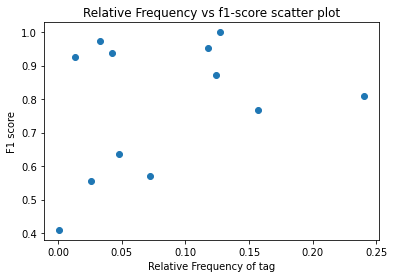

In [ ]:
histogram_plot([val2tag[i] for i in range(1,13)],per_pos_dict_test,data='test')
histogram_plot([val2tag[i] for i in range(1,13)],per_pos_dict_train,data='train')

In [ ]:
print(confusion_matrix_test)
print(confusion_matrix_train)
print(per_pos_dict_test)
print(per_pos_dict_train)

[[224965  21701   2019      0    456  23220   4337     72    360   2666
     425    683]
 [ 18200 138233   4693      0    806   6034   6399     86    339   3233
     132     82]
 [  3779   4664 130008      4   1233   1902   2889     69    840   8204
      14     22]
 [    87    189    140 147557     44      4     50      1      0      5
       3     25]
 [  1002    900   2053      1 132603   1412   1394     58   1472    482
     247     20]
 [ 19266   6032    949      0    500  45663   3444     67     19    560
     149     75]
 [  4531   8120   2447      0    520   4935  36337    227     99   1093
       9      9]
 [   364    570    174      1    393    143    375  37518     27     11
       7      5]
 [   615    751    699      2    446     42    398     12  46129    178
      13     13]
 [  1444   1511   1558      0     15    197    592     34     40  13368
       9     10]
 [   988     55     18      0      3    114     16      5      0     10
   13864      7]
 [   317     24      